In [1]:
import imutils
import cv2 as cv
import numpy as np
import random as rng
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [18, 10]

In [2]:
def getCenter(contours):
    M = cv.moments(contours)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return cX, cY

def measurements(contours):
    statsArea = []
    statsPerimeter = []
    statsWidth = []
    statsHeight = []
    
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt, True)
        (x, y), (w, h), angle = cv.minAreaRect(cnt)
        if angle > -45:
            print("Blob {}\t- Area: {} cm^2\tPerimetro: {} cm\tWidth: {} cm\tHeight: {} cm".format(i, round(area/100,2), round(perimeter/100,2), round(w/100,2), round(h/100,2)))
            statsWidth.append(w)
            statsHeight.append(h)
        else:
            print("Blob {}\t- Area: {} cm^2\tPerimetro: {} cm\tWidth: {} cm\tHeight: {} cm".format(i, round(area/100,2), round(perimeter/100,2), round(h/100,2), round(w/100,2)))
            statsWidth.append(h)
            statsHeight.append(w)
        statsArea.append(area)
        statsPerimeter.append(perimeter)
    
    print("\nArea Minima: {} cm\t\tArea Massima: {} cm\t\tArea Media: {} cm".format(round(np.min(np.array(statsArea))/100,2), round(np.max(np.array(statsArea))/100,2), round(np.mean(np.array(statsArea))/100,2)))
    print("Perimetro Minimo: {} cm\tPerimetro Massimo: {} cm\tPerimetro Medio: {} cm".format(round(np.min(np.array(statsPerimeter))/100,2), round(np.max(np.array(statsPerimeter))/100,2), round(np.mean(np.array(statsPerimeter))/100,2)))
    print("Width Minima: {} cm\t\tWidth Massima: {} cm\t\tWidth Media: {} cm".format(round(np.min(np.array(statsWidth))/100,2), round(np.max(np.array(statsWidth))/100,2), round(np.mean(np.array(statsWidth))/100,2)))
    print("Height Minima: {} cm\t\tHeight Massima: {} cm\t\tHeight Media: {} cm".format(round(np.min(np.array(statsHeight))/100,2), round(np.max(np.array(statsHeight))/100,2), round(np.mean(np.array(statsHeight))/100,2)))

def distanceCalculate(p1, p2):
    dis = ((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5
    dis = abs(dis)
    return dis

def cntDistanceCompare(contoursA, contoursB):
    minimo = -1
    for contourA in contoursA:
        for contourB in contoursB:
            distanza = distanceCalculate(contourA[0], contourB[0])
            if minimo == -1 or distanza < minimo:
                minimo = distanza
    return minimo

def cntDistanceCompare2(contoursA, contoursB):
    cumMinDistList = []
    for contourA in contoursA:
        indMinDistList = []
        for contourB in contoursB:
            minDist = distanceCalculate(contourA[0], contourB[0])
            indMinDistList.append(minDist)
        cumMinDistList.append(min(indMinDistList))
    return min(cumMinDistList)

def contourDetection(closing):
    # convert the image to grayscale format
    img_gray = cv.cvtColor(closing, cv.COLOR_BGR2GRAY)

    # apply binary thresholding
    ret, thresh_gray = cv.threshold(img_gray, 200, 255, cv.THRESH_BINARY)
    
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    _, contours, hierarchy = cv.findContours(image=thresh_gray, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    
    # sort the contours according to the provided method
    (contours, boundingBoxes) = sort_contours(contours)
    
    cnt = []
    for i in range(len(contours)):
        if cv.contourArea(contours[i]) > 0:
            cnt.append(contours[i])
    print("Blob trovati: {}\n".format(len(cnt)))
    
    # draw contours on the original image
    src_copy1 = src.copy()
    cv.drawContours(image=src_copy1, contours=cnt, contourIdx=-1, color=(0, 255, 0), thickness=3, lineType=cv.LINE_AA)

    # Show in a window
    print("dtype: {}".format(src_copy1.dtype))
    print("shape: {}".format(src_copy1.shape))
    plt.imshow(src_copy1)
    plt.show()
    
    # draw Bounding Rectangle on the original image
    src_copy2 = src.copy()
    
    # Straight Bounding Rotated Rectangle
    for i in range(len(cnt)):
        rect = cv.minAreaRect(cnt[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(src_copy2, [box], 0, (0, 255, 0), 2)

    # Show in a window
    print("\ndtype: {}".format(src_copy2.dtype))
    print("shape: {}".format(src_copy2.shape))
    plt.imshow(src_copy2)
    plt.show()
    
    # draw only contours
    drawing = np.zeros((thresh_gray.shape[0], thresh_gray.shape[1], 3), dtype=np.uint8)
    for i in range(len(cnt)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, cnt, i, color, 2, cv.LINE_8, hierarchy, 0)
        x, y, w, h = cv.boundingRect(cnt[i])
        cv.putText(drawing, "{}".format(i), (int(x+(w/2)), int(y+(h/2))), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show in a window
    print("\ndtype: {}".format(drawing.dtype))
    print("shape: {}".format(drawing.shape))
    plt.imshow(drawing)
    plt.show()
    
    return cnt

In [3]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

## Original Image

dtype: uint8
shape: (536, 2435, 3)


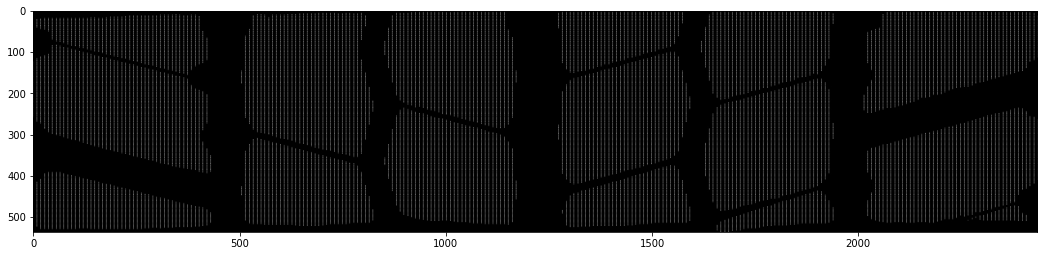

In [27]:
src = cv.imread("res1.jpg")

# Show in a window
print("dtype: {}".format(src.dtype))
print("shape: {}".format(src.shape))
plt.imshow(src)
plt.show()

## BLOB - Morphological Transformations - Closing

dtype: uint8
shape: (536, 2435, 3)


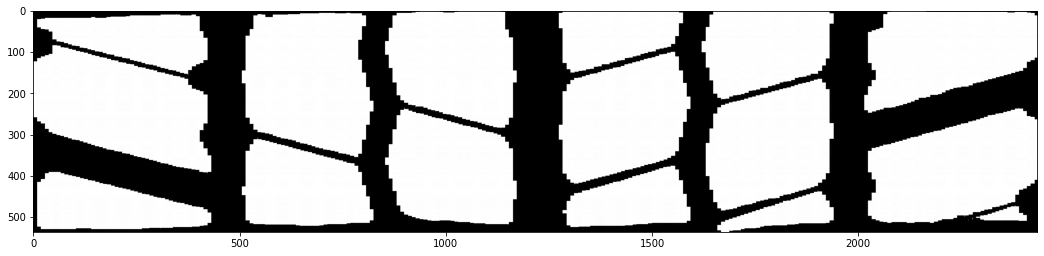

In [28]:
kernel_blob = np.ones((5,10), np.uint8)
closing_blob = cv.morphologyEx(src, cv.MORPH_CLOSE, kernel_blob)

# Show in a window
print("dtype: {}".format(closing_blob.dtype))
print("shape: {}".format(closing_blob.shape))
plt.imshow(closing_blob)
plt.show()

## MACRO_BLOB - Morphological Transformations - Closing

dtype: uint8
shape: (536, 2435, 3)


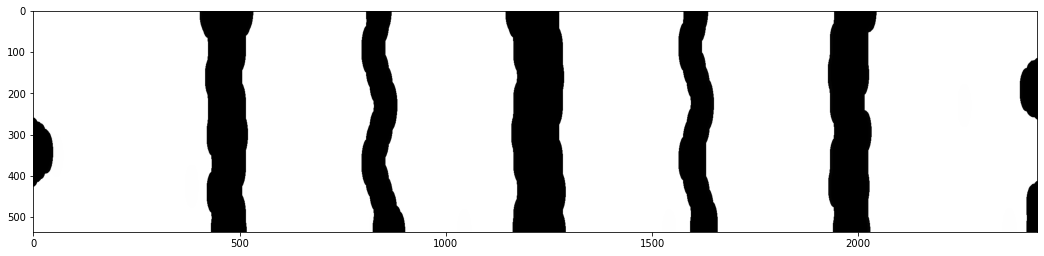

In [29]:
kernel_macro_blob = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30, 100))
closing_macro_blob = cv.morphologyEx(closing_blob, cv.MORPH_CLOSE, kernel_macro_blob)

# Show in a window
print("dtype: {}".format(closing_macro_blob.dtype))
print("shape: {}".format(closing_macro_blob.shape))
plt.imshow(closing_macro_blob)
plt.show()

## MACRO_BLOB - Contour Detection

Blob trovati: 6

dtype: uint8
shape: (536, 2435, 3)


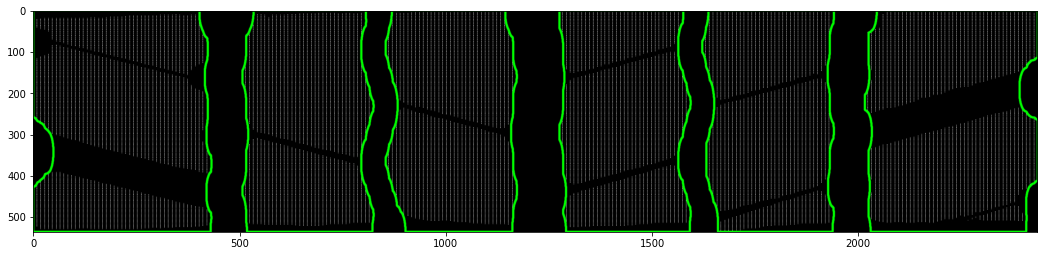


dtype: uint8
shape: (536, 2435, 3)


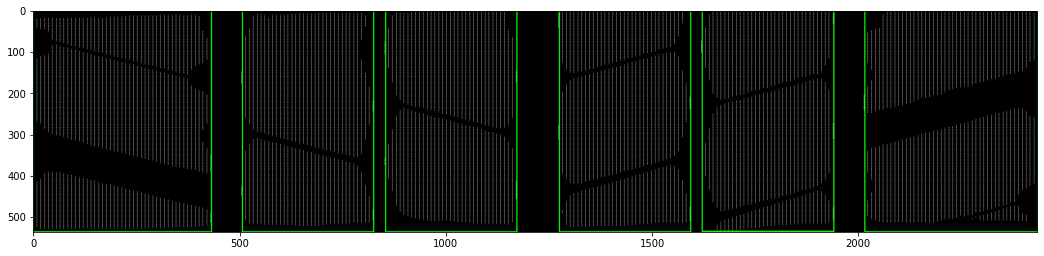


dtype: uint8
shape: (536, 2435, 3)


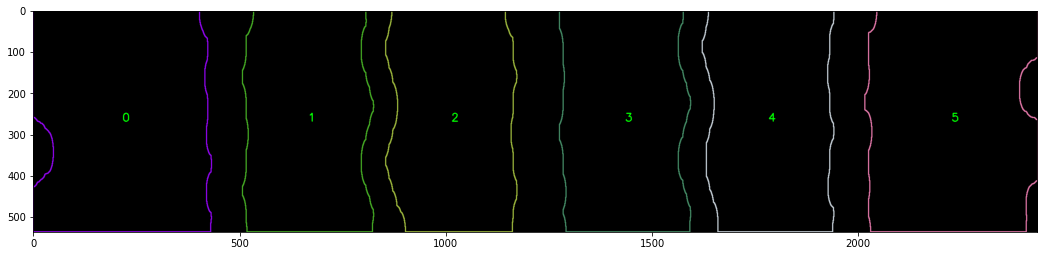

In [30]:
contours_macro_blob = contourDetection(closing_macro_blob)

In [8]:
stats = []
for n in range(len(contours_macro_blob)-1):
    d = cntDistanceCompare(contours_macro_blob[n], contours_macro_blob[n+1])
    print("MacroBlob {} - MacroBlob {} -- Distanza: {} cm".format(n, n+1, round(d/100,2)))
    stats.append(d)

print("\nDistanza Minima: {} cm\tDistanza Massima: {} cm\tDistanza Media: {} cm".format(round(np.min(np.array(stats))/100,2), round(np.max(np.array(stats))/100,2), round(np.mean(np.array(stats))/100,2)))

MacroBlob 0 - MacroBlob 1 -- Distanza: 0.84 cm
MacroBlob 1 - MacroBlob 2 -- Distanza: 0.56 cm
MacroBlob 2 - MacroBlob 3 -- Distanza: 1.14 cm
MacroBlob 3 - MacroBlob 4 -- Distanza: 0.56 cm
MacroBlob 4 - MacroBlob 5 -- Distanza: 0.82 cm

Distanza Minima: 0.56 cm	Distanza Massima: 1.14 cm	Distanza Media: 0.79 cm


## MACRO_BLOB - Area, Perimeter, Width and Height Measurements

In [9]:
measurements(contours_macro_blob)

Blob 0	- Area: 2193.24 cm^2	Perimetro: 19.88 cm	Width: 4.32 cm	Height: 5.35 cm
Blob 1	- Area: 1558.69 cm^2	Perimetro: 17.17 cm	Width: 3.18 cm	Height: 5.35 cm
Blob 2	- Area: 1557.21 cm^2	Perimetro: 16.82 cm	Width: 3.18 cm	Height: 5.35 cm
Blob 3	- Area: 1565.81 cm^2	Perimetro: 17.35 cm	Width: 3.18 cm	Height: 5.35 cm
Blob 4	- Area: 1565.36 cm^2	Perimetro: 17.16 cm	Width: 3.19 cm	Height: 5.35 cm
Blob 5	- Area: 2098.29 cm^2	Perimetro: 19.36 cm	Width: 4.19 cm	Height: 5.35 cm

Area Minima: 1557.21 cm		Area Massima: 2193.24 cm		Area Media: 1756.43 cm
Perimetro Minimo: 16.82 cm	Perimetro Massimo: 19.88 cm	Perimetro Medio: 17.96 cm
Width Minima: 3.18 cm		Width Massima: 4.32 cm		Width Media: 3.54 cm
Height Minima: 5.35 cm		Height Massima: 5.35 cm		Height Media: 5.35 cm


## BLOB - Contour Detection

Blob trovati: 16

dtype: uint8
shape: (536, 2435, 3)


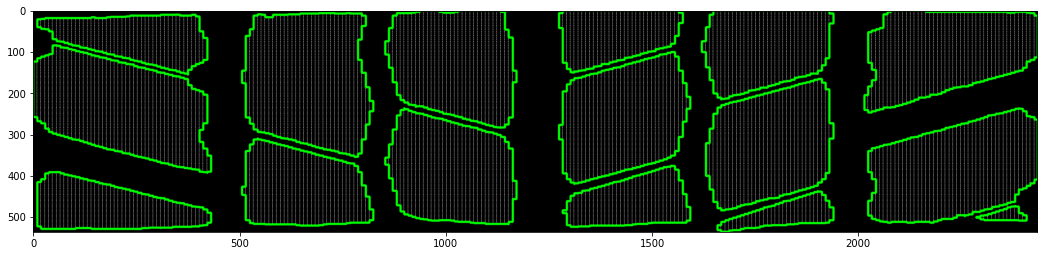


dtype: uint8
shape: (536, 2435, 3)


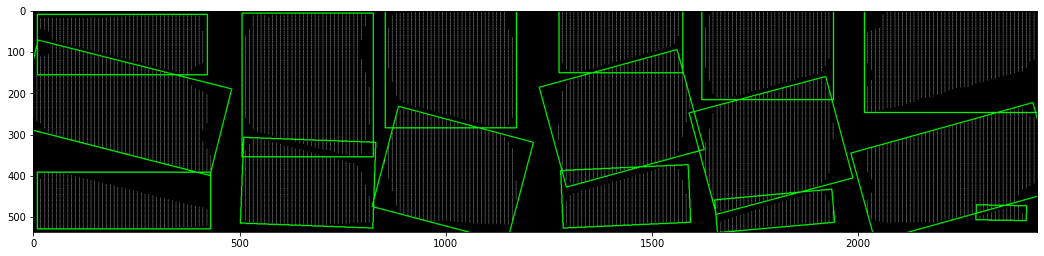


dtype: uint8
shape: (536, 2435, 3)


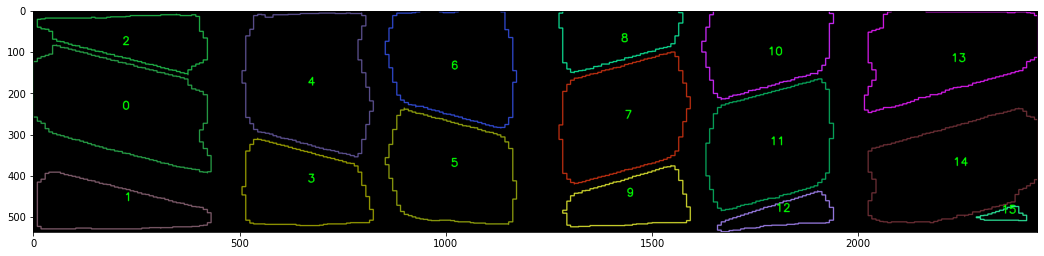

In [10]:
contours_blob = contourDetection(closing_blob)

## BLOB - Area and Perimeter Measurements

In [11]:
measurements(contours_blob)

Blob 0	- Area: 871.35 cm^2	Perimetro: 14.62 cm	Width: 4.83 cm	Height: 2.15 cm
Blob 1	- Area: 389.53 cm^2	Perimetro: 10.9 cm	Width: 4.21 cm	Height: 1.37 cm
Blob 2	- Area: 374.12 cm^2	Perimetro: 10.89 cm	Width: 4.12 cm	Height: 1.46 cm
Blob 3	- Area: 508.44 cm^2	Perimetro: 10.31 cm	Width: 3.21 cm	Height: 2.07 cm
Blob 4	- Area: 889.35 cm^2	Perimetro: 13.54 cm	Width: 3.18 cm	Height: 3.47 cm
Blob 5	- Area: 683.04 cm^2	Perimetro: 11.67 cm	Width: 3.38 cm	Height: 2.5 cm
Blob 6	- Area: 723.67 cm^2	Perimetro: 11.92 cm	Width: 3.18 cm	Height: 2.84 cm
Blob 7	- Area: 733.65 cm^2	Perimetro: 12.35 cm	Width: 3.47 cm	Height: 2.5 cm
Blob 8	- Area: 336.25 cm^2	Perimetro: 8.83 cm	Width: 3.0 cm	Height: 1.51 cm
Blob 9	- Area: 310.15 cm^2	Perimetro: 8.89 cm	Width: 3.09 cm	Height: 1.4 cm
Blob 10	- Area: 532.25 cm^2	Perimetro: 10.5 cm	Width: 3.19 cm	Height: 2.16 cm
Blob 11	- Area: 731.1 cm^2	Perimetro: 12.17 cm	Width: 3.43 cm	Height: 2.54 cm
Blob 12	- Area: 134.58 cm^2	Perimetro: 7.34 cm	Width: 2.85 cm	Height: 0

## MACRO_BLOB - BLOB - Distance

In [12]:
macro_blob = {'0': set({}), '1': set({}), '2': set({}), '3': set({}), '4': set({}), '5': set({})}

for i in range(len(contours_macro_blob)):
    for j in range(len(contours_blob)):
        x1 = contours_blob[j][0][0][0]
        y1 = contours_blob[j][0][0][1]
        ppt1 = cv.pointPolygonTest(contours_macro_blob[i], (x1,y1), False)
        if (ppt1 == 0 or ppt1 == 1):
            macro_blob[str(i)].update({j})

print(macro_blob)

{'0': {0, 1, 2}, '1': {3, 4}, '2': {5, 6}, '3': {8, 9, 7}, '4': {10, 11, 12}, '5': {13, 14, 15}}


In [13]:
for key, value in macro_blob.items():
    blob = value
    thisset = set({})
    for j in blob:
        minimoAttuale = float("inf")
        indiceMinimoAttuale = -1
        banana = blob.copy()
        banana.discard(j)
        for k in banana:
            cX1, cY1 = getCenter(contours_blob[j])
            cX2, cY2 = getCenter(contours_blob[k])
            centerDistance = distanceCalculate((cX1, cY1), (cX2, cY2))
            if (centerDistance < minimoAttuale):
                minimoAttuale = centerDistance
                indiceMinimoAttuale = k
        check = sorted({j, indiceMinimoAttuale})
        if (indiceMinimoAttuale > -1 and "{},{}".format(check[0], check[1]) not in thisset):
            d = cntDistanceCompare(contours_blob[check[0]], contours_blob[check[1]])
            print("MacroBlob {} -- Blob {} - Blob {} -- Distanza: {} cm".format(key, check[0], check[1], round(d/100,2)))
            thisset.add("{},{}".format(check[0], check[1]))

MacroBlob 0 -- Blob 0 - Blob 2 -- Distanza: 0.09 cm
MacroBlob 0 -- Blob 0 - Blob 1 -- Distanza: 0.8 cm
MacroBlob 1 -- Blob 3 - Blob 4 -- Distanza: 0.15 cm
MacroBlob 2 -- Blob 5 - Blob 6 -- Distanza: 0.11 cm
MacroBlob 3 -- Blob 7 - Blob 8 -- Distanza: 0.11 cm
MacroBlob 3 -- Blob 7 - Blob 9 -- Distanza: 0.16 cm
MacroBlob 4 -- Blob 10 - Blob 11 -- Distanza: 0.1 cm
MacroBlob 4 -- Blob 11 - Blob 12 -- Distanza: 0.12 cm
MacroBlob 5 -- Blob 13 - Blob 14 -- Distanza: 0.8 cm
MacroBlob 5 -- Blob 14 - Blob 15 -- Distanza: 0.07 cm


In [ ]:
for i in range(len(contours_macro_blob)):
    for j in range(len(contours_blob)):
        for k in range(len(contours_blob)):
            x1 = contours_blob[j][0][0][0]
            y1 = contours_blob[j][0][0][1]
            x2 = contours_blob[k][0][0][0]
            y2 = contours_blob[k][0][0][1]
            ppt1 = cv.pointPolygonTest(contours_macro_blob[i], (x1,y1), False) # Returns +1, -1, or 0 to indicate if a point is inside, outside, or on the contour
            ppt2 = cv.pointPolygonTest(contours_macro_blob[i], (x2,y2), False)
            if (ppt1 == 0 or ppt1 == 1) and (ppt2 == 0 or ppt2 == 1) and j != k:
                d = cntDistanceCompare(contours_blob[j], contours_blob[k])
                print("MacroBlob {} -- Blob {} - Blob {} -- Distanza: {} cm".format(i, j, k, round(d/100,2)))

In [ ]:
prova = src.copy()

# Straight Bounding Rectangle
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(prova,(x,y),(x+w,y+h),(0,255,0),2)
cv.putText(prova, 'Bound', (x+30, y+30), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

# Rotated Rectangle
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(prova,[box],0,(0,255,0),2)

plt.imshow(prova)
plt.show()